In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt install libgraphviz-dev
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pygraphviz
!pip install markov_clustering
!pip install leidenalg
!pip install cdlib
!pip install Faker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

In [1]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from termcolor import cprint
import markov_clustering as mc
import igraph as ig
import leidenalg as la
import time
import numpy as np
import itertools as it
import numpy as np
from pulp import *
import seaborn as sns 

In [ ]:
from faker import Factory
fake=Factory.create()

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, NodesAndLinkedEdges, LabelSet, BoxZoomTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues256, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Viridis256, Oranges256, Blues8
from bokeh.transform import linear_cmap

In [ ]:
aisles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/departments.csv')
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/orders.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/order_products__prior.csv')
order_products_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/order_products__train.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/products.csv')

In [ ]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')

In [ ]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
order_products_v1 = order_products.sample(n=1000, replace=False, random_state=42) # random sampling to minimise the data set to run in the local
order_products_v1['user_id'] = order_products_v1['user_id'].astype(int)
order_products_v1['aisle'] = order_products_v1['aisle'].astype(str)

In [ ]:
order_products_v1.shape

(1000, 15)

# **`Reduce memory footprint`**

In [ ]:
def reduce_memory(df):
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [ ]:
order_products = reduce_memory(order_products)
aisles = reduce_memory(aisles)
departments = reduce_memory(departments)
orders = reduce_memory(orders)
order_products_prior = reduce_memory(order_products_prior)
order_products_train = reduce_memory(order_products_train)
products = reduce_memory(products)
order_products_v1 = reduce_memory(order_products_v1)

Memory usage of properties dataframe is : 3959.2882080078125  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1948.7121648788452  MB
This is  49.21875 % of the initial size
Memory usage of properties dataframe is : 0.002166748046875  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.001399993896484375  MB
This is  64.61267605633803 % of the initial size
Memory usage of properties dataframe is : 0.0004425048828125  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.00030231475830078125  MB
This is  68.31896551724138 % of the initial size
Memory usage of properties dataframe is : 182.7056655883789  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  68.5147008895874  MB
This is  37.50004175784318 % of the initial size
Memory usage of properties dataframe is : 989.8221740722656  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  340.2514524459839  MB
This is  34.375008093235806 % of the initial size
Memory usage of properties dataframe is : 4

# **`Observed variable: user and dept relation (undirected and non-weighted graph)`**

## **`Louvain Community Detection on un-directed and non-weighted graph`**

In [ ]:
def simple_Louvain(G, random_state=42, resolution=1.0,weight=None):
    if weight is None:
      partition = community_louvain.best_partition(G, random_state=random_state, resolution=resolution)
    else:
      partition = community_louvain.best_partition(G, random_state=random_state, resolution=resolution, weight=weight)
    modularity = community_louvain.modularity(partition, G)
    pos = graphviz_layout(G)
    max_k_w = []
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        max_k_w = max_k_w + [list_nodes]

    
    node_mapping = {}
    map_v = 0
    for node in G.nodes():
        node_mapping[node] = map_v
        map_v += 1

    community_num_group = len(max_k_w)
    color_list_community = [[] for i in range(len(G.nodes()))]
    
    # color
    for i in G.nodes():
        for j in range(community_num_group):
            if i in max_k_w[j]:
                color_list_community[node_mapping[i]] = j
    
    return G, pos, color_list_community, community_num_group, max_k_w, modularity, partition

<h2>Cluster Insights: Louvian</h2>

In [ ]:
user_dept = order_products_v1[['user_id','aisle_id']].itertuples(index=False, name=None)

In [ ]:
g_test = nx.Graph()
user_vertex = order_products_v1['user_id'].unique().tolist()
for each_user_id in user_vertex:
  g_test.add_node(each_user_id, type='user_id')
dept_info = order_products_v1['aisle_id'].unique().tolist()
for dept_id in dept_info:
  g_test.add_node(dept_id, type='aisle_id')

g_test.add_edges_from(list(user_dept))

In [ ]:
g_test.nodes(data=True)

In [ ]:
G, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g_test)

In [ ]:
cluster_analysis = []
for i in range(0,len(max_k_w)):
  for cluster_nodes in max_k_w[i]:
    node_type = g_test.nodes[cluster_nodes]['type']
    row = {'node': cluster_nodes, 'type':node_type, 'cluster_id':i}
    cluster_analysis.append(row)

cluster_analysis = pd.DataFrame.from_records(cluster_analysis)
cluster_analysis.head()

,node,type,cluster_id
0,8940,user_id,0
1,7,aisle_id,0
2,7293,user_id,1
3,133196,user_id,1
4,104701,user_id,1


In [ ]:
pd.options.display.max_rows = 100

In [ ]:
cluster_analysis.groupby(by=['cluster_id','type']).size()

cluster_id  type    
0           aisle_id     1
            user_id      1
1           aisle_id     1
            user_id     94
2           aisle_id     1
                        ..
101         user_id      2
102         aisle_id     1
            user_id      1
103         aisle_id     1
            user_id      1
Length: 208, dtype: int64

In [ ]:
g = nx.Graph()
g.add_edges_from(list(user_dept))

In [ ]:
G, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g_test)

In [ ]:
modularity

0.8222024474823294

In [ ]:
edges = G.edges()
Feature_color_sub = color_list_community
node_size = 50

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [ ]:
cprint(f"modularity : {round(modularity,4)} community_num_ {community_num_group}", 'blue', attrs=['bold'])

In [ ]:
nodes = list(partition.keys())
community_num = list(partition.values())

community_meta = pd.DataFrame({'nodes':nodes,'community_num': community_num})
community_meta = community_meta['community_num'].value_counts().sort_values(ascending=False).to_frame('node_count_in_the_community').reset_index().rename(columns={'index':'community_id'})

In [ ]:
community_meta.head()

In [ ]:
user_dept_histogram = sns.histplot(data = community_meta,x='node_count_in_the_community', kde=True)
user_dept_histogram.figure.savefig("user_dept_histogram.png")

In [ ]:
dendo = community_louvain.generate_dendrogram(G)
for level in range(len(dendo)):
    print(("partition at level", level, "is", community_louvain.partition_at_level(dendo, level))," modularity", community_louvain.modularity(community_louvain.partition_at_level(dendo,level),G), end='\n\n')

<h2>Community Detection: User Asile Lovain</h2>

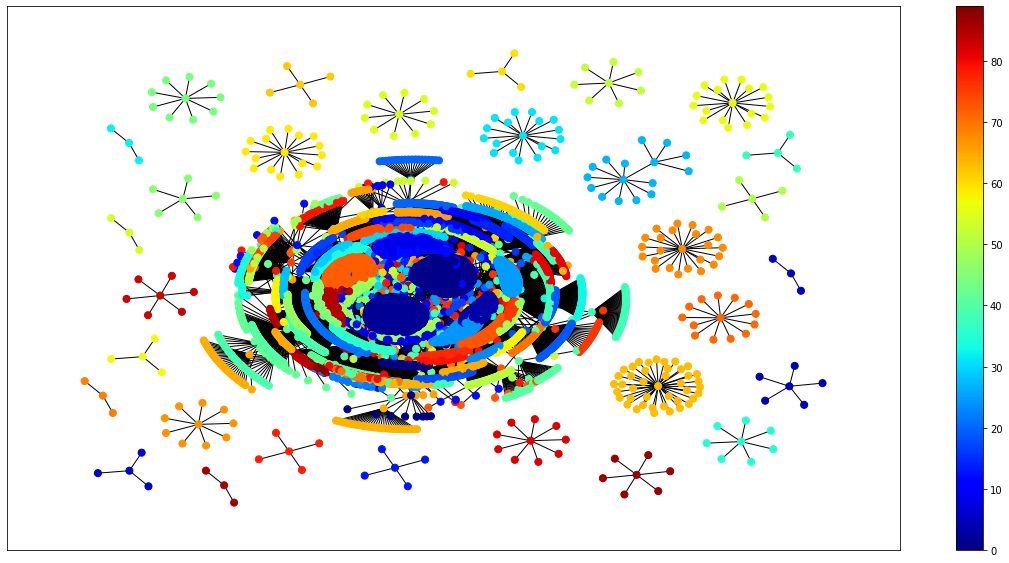

modularity : 0.9155 community_num_ 89


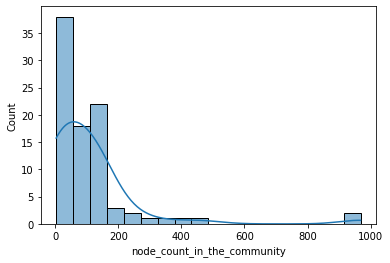

In [ ]:
user_aisle = order_products_v1[['user_id','aisle_id']].itertuples(index=False, name=None)
g = nx.Graph()
g.add_edges_from(list(user_aisle))
G, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g)
edges = G.edges()
Feature_color_sub = color_list_community
node_size = 50

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

cprint(f"modularity : {round(modularity,4)} community_num_ {community_num_group}", 'blue', attrs=['bold'])
nodes = list(partition.keys())
community_num = list(partition.values())

community_meta = pd.DataFrame({'nodes':nodes,'community_num': community_num})
community_meta = community_meta['community_num'].value_counts().sort_values(ascending=False).to_frame('node_count_in_the_community').reset_index().rename(columns={'index':'community_id'})
user_product_histogram = sns.histplot(data = community_meta,x='node_count_in_the_community', kde=True)
user_product_histogram.figure.savefig("user_asile_histogram.png")

## **`Markov Clustering un-directed and non-weighted graph`**

In [ ]:
adjacency_matrix = nx.to_scipy_sparse_matrix(g)

Hyperparameter Tuning

In [ ]:
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(adjacency_matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    msg = f"inflation: {inflation}  modularity: {Q}"
    cprint(msg, 'blue')

inflation: 1.5  modularity: 0.8539685065405904
inflation: 1.6  modularity: 0.8544058313426792
inflation: 1.7  modularity: 0.8594530083837189
inflation: 1.8  modularity: 0.8635251866932165


In [ ]:
markov_communities = mc.run_mcl(adjacency_matrix, inflation=1.7)
markov_clusters = mc.get_clusters(markov_communities)

In [ ]:
markov_modularity = mc.modularity(matrix=markov_communities, clusters=markov_clusters)
msg = f"number of markov cluster {len(markov_clusters)} with modularity value {round(markov_modularity,2)}"
cprint(msg, 'blue')

## **`Leiden Community Detection un-directed and non-weighted graph`**

In [ ]:
leiden_partition = la.find_partition(ig.Graph.from_networkx(g), la.ModularityVertexPartition, seed=42, n_iterations=10);

In [ ]:
cprint(leiden_partition.summary() + " with modularity: "+str(round(leiden_partition.q,4)),'blue', attrs=['bold'])

Clustering with 9464 elements and 20 clusters with modularity: 0.8222


In [ ]:
modularity = round(leiden_partition.q,4)

0.8222


In [ ]:
leiden_partition.as_cover

851

# **`Community Influence Maximization: for undirected graph`**

In [ ]:
def IC(g,S,p=0.5,mc=1000):
    
    spread_list = []
    for i in range(mc):    
        new_active_nodes, A = S[:], S[:]
        while new_active_nodes:
            new_ones = []
            for node in new_active_nodes:
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))
            new_active_nodes = list(set(new_ones) - set(A))
            A += new_active_nodes
        spread_list.append(len(A))
    return(np.mean(spread_list))

## Greedy Algorithm

In [ ]:
def greedy(g,k,p=0.1,mc=1000):
  
    S, spread, timelapse, start_time = [], [], [], time.time()
    for _ in range(k):
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):
            s = IC(g,S + [j],p,mc)
            if s > best_spread:
                best_spread, node = s, j
        S.append(node)
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

## CELF Algorithm

In [ ]:
def celf(g,k,p=0.1,mc=1000):

    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    for _ in range(k-1):    
        check, node_lookup = False, 0
        while not check:
            node_lookup += 1
            current = Q[0][0]
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)
            Q = sorted(Q, key = lambda x: x[1], reverse = True)
            check = (Q[0][0] == current)
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [ ]:
celf_nodes = celf(ig.Graph.from_networkx(g),2,p = 0.2,mc = 10)
cprint(celf_nodes, 'blue')

([5, 3], [12.6, 21.6], [0.4568934440612793, 0.46239447593688965], [591, 1])


In [ ]:
greedy_output_nodes = greedy(ig.Graph.from_networkx(g),2,p = 0.2,mc = 10)
cprint(greedy_output_nodes, 'blue')

([5, 3], [12.6, 21.6], [0.4567892551422119, 3.1595358848571777])


# **`Weighted Network: User vs product brought from departments`**

In [ ]:
cross_df = pd.crosstab(index=order_products_v1['user_id'], columns=order_products_v1['department'])
cross_df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
140,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
612,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
616,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
norm_user_dept = cross_df.div(cross_df.sum(axis=1), axis=0)

In [ ]:
norm_user_dept = norm_user_dept.reset_index()

In [ ]:
all_nodes_edges = []
for index,row in norm_user_dept.iterrows():
    user_id = row['user_id']
    row.drop(index=['user_id'], inplace=True)
    non_zero_relations = row[row > 0.0]
    nodes_edges = non_zero_relations.to_frame('weight').reset_index()
    nodes_edges['user_id']=int(user_id)
    nodes_edges = nodes_edges.rename(columns={'department':'node1','user_id':'node2'})
    nodes_edges = nodes_edges[['node1','node2','weight']]
    nodes_edges['node1'] = nodes_edges['node1'].astype(str)
    nodes_edges['node2'] = nodes_edges['node2'].astype(str)
    relations = list(nodes_edges.itertuples(index=False, name=None))
    all_nodes_edges.append(relations)
  
relation_generator = it.chain.from_iterable(all_nodes_edges)
networkx_edges = []
for relation in relation_generator:
    networkx_edges.append(relation)

In [ ]:
g2 = nx.Graph()

user_vertext = norm_user_dept['user_id'].unique().tolist()
for each_user_id in user_vertex:
  g2.add_node(each_user_id, type='user_id')

In [ ]:
dept_info = order_products_v1['department'].unique().tolist()
for dept_id in dept_info:
  g2.add_node(dept_id, type='department')

In [ ]:
g2.add_weighted_edges_from(networkx_edges)

In [ ]:
g2, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g2, resolution=0.1, random_state=42, weight='weight')

<h2>Cluster Insights: Louvain</h2>

In [ ]:
cluster_analysis = []
for i in range(0,len(max_k_w)):
  for cluster_nodes in max_k_w[i]:
    try:
      node_type = g2.nodes[cluster_nodes]['type']
      row = {'node': cluster_nodes, 'type':node_type, 'cluster_id':i}
      cluster_analysis.append(row)
    except:
      pass

cluster_analysis = pd.DataFrame.from_records(cluster_analysis)
cluster_analysis.head()

,node,type,cluster_id
0,135284,user_id,0
1,7293,user_id,1
2,111385,user_id,2
3,147365,user_id,3
4,99290,user_id,4


In [ ]:
cluster_analysis.groupby(by=['cluster_id','type']).size()

cluster_id  type      
0           user_id       1
1           user_id       1
2           user_id       1
3           user_id       1
4           user_id       1
                         ..
1010        department    1
1011        department    1
1012        department    1
1051        department    1
1427        department    1
Length: 1013, dtype: int64

## Louvian

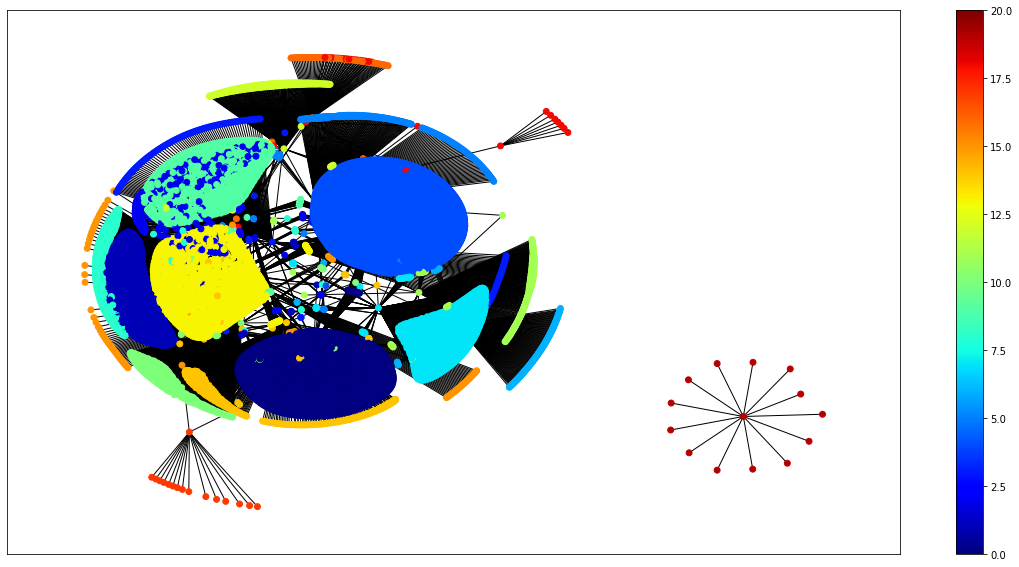

In [ ]:
g2, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g2, resolution=1.0, random_state=42, weight='weight')
edges = g2.edges()
Feature_color_sub = color_list_community
node_size = 35

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(g2, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(g2, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [ ]:
# louvain_partition = community_louvain.best_partition(g2, resolution=1.0, random_state=42, weight='weight')
louvain_partition=partition

In [ ]:
cprint(f"modularity {community_louvain.modularity(louvain_partition,g2)}", 'blue', attrs=['bold'])
nodes = list(louvain_partition.keys())
community_num = list(louvain_partition.values())
community_info = pd.DataFrame({'nodes':nodes,'community_num':community_num})
cprint(f"unique communities: {community_info['community_num'].unique()} community count {community_info['community_num'].nunique()}", "blue", attrs=['bold'])

modularity 0.8408092592582211
unique communities: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] community count 20


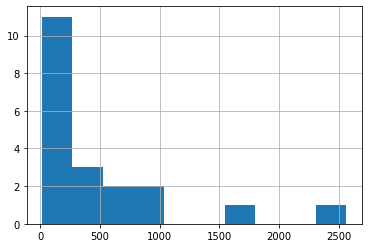

In [ ]:
community_info['community_num'].value_counts().sort_values(ascending=False).to_frame('community_size').reset_index().rename(columns={'index':'community_num'})['community_size'].hist()

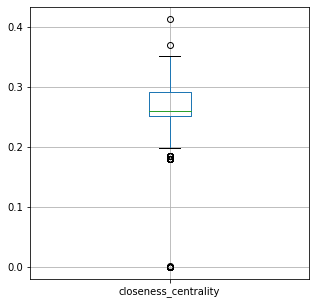

In [ ]:
louvain_closeness = pd.DataFrame.from_dict([nx.closeness_centrality(g2)])
louvain_closeness.iloc[0].to_frame('closeness_centrality').boxplot(figsize=(5,5), grid=True)

In [ ]:
louvain_first_quantile = louvain_closeness.iloc[0].to_frame('closeness_centrality').quantile(0.25).squeeze()
louvain_second_quantile = louvain_closeness.iloc[0].to_frame('closeness_centrality').quantile(0.50).squeeze()
louvain_third_quantile = louvain_closeness.iloc[0].to_frame('closeness_centrality').quantile(0.75).squeeze()

In [ ]:
msg = f"first_quantile: {louvain_first_quantile} second_quantile: {louvain_second_quantile} third_quantile:{louvain_third_quantile}"
cprint(msg, 'blue', attrs=['bold'])

first_quantile: 0.2517478714152245 second_quantile: 0.2605903989581682 third_quantile:0.29220401002821106


Text(0, 0.5, 'Frequency')

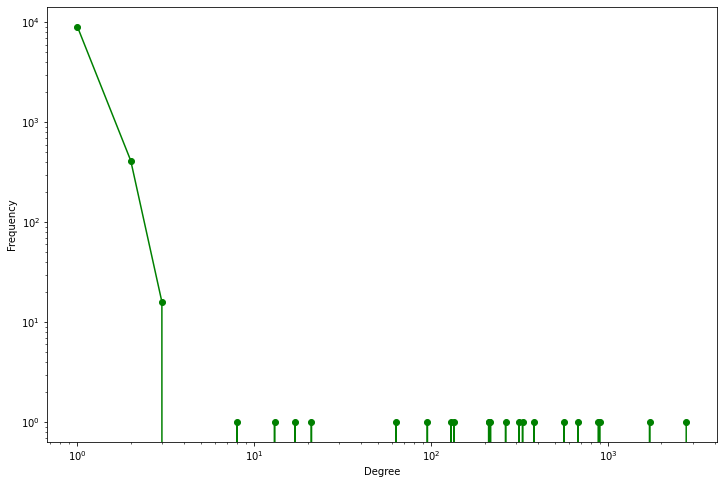

In [ ]:
m=1
degree_freq = nx.degree_histogram(g2)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8))
plt.loglog(degrees[m:], degree_freq[m:],'go-')
plt.xlabel('Degree')
plt.ylabel('Frequency')

## Leiden

In [ ]:
leiden_partition = la.find_partition(ig.Graph.from_networkx(g2), la.ModularityVertexPartition, seed=42, n_iterations=20, weights='weight')

In [ ]:
cprint(leiden_partition.summary() + " with modularity: " + str(round(leiden_partition.q,4)),'blue', attrs=['bold'])

Clustering with 9466 elements and 20 clusters with modularity: 0.8222


In [ ]:
total_community_no = len(set(leiden_partition.membership))
color_list=[]
for i in range(0,total_community_no+1):
    color_list.append(fake.hex_color())

In [ ]:
modularity_class = {}
modularity_color = {}

for i in range(0, total_community_no):
    sub_graphs = leiden_partition.subgraphs()[i].to_networkx().nodes(data=True)
    sub_graphs = list(sub_graphs)
    node_list = [x[1]['_nx_name'] for x in sub_graphs]
    for node in node_list:
        modularity_class[node] = i
        modularity_color[node] = color_list[i]

In [ ]:
# Add modularity class and color as attributes from the network above
nx.set_node_attributes(g2, modularity_class, 'community_id')
nx.set_node_attributes(g2, modularity_color, 'community_color')

In [ ]:
edge_highlight_color='yellow'
node_highlight_color = 'skyblue'
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
# size_by_this_attribute = 'degree'
size_by_this_attribute = 15
color_by_this_attribute = 'community_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'User vs Product Per Department Purchase Pattern'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@degree"),
         ("Community id", "@community_id"),
        ("Community Color", "$color[swatch]:community_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1), title=title, plot_width=1400, plot_height=900)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(g2, nx.spring_layout, scale=10, center=(0, 0))


#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)


#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()
plot.add_tools(BoxZoomTool())
plot.renderers.append(network_graph)

#Add Labels
# x, y = zip(*network_graph.layout_provider.graph_layout.values())
# node_labels = list(g2.nodes())
# source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
# labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
# plot.renderers.append(labels)

In [ ]:
output_notebook()

In [ ]:
show(plot, notebook_handle=True)

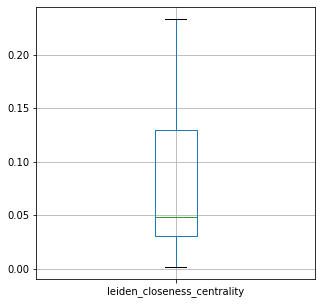

In [ ]:
leiden_closeness = pd.DataFrame.from_dict([nx.closeness_centrality(g2)])
leiden_closeness.iloc[0].to_frame('leiden_closeness_centrality').boxplot(figsize=(5,5), grid=True)

In [ ]:
leiden_first_quantile = leiden_closeness.iloc[0].to_frame('leiden_closeness_centrality').quantile(0.25).squeeze()
leiden_second_quantile = leiden_closeness.iloc[0].to_frame('leiden_closeness_centrality').quantile(0.50).squeeze()
leiden_third_quantile = leiden_closeness.iloc[0].to_frame('leiden_closeness_centrality').quantile(0.75).squeeze()
msg = f"first_quantile: {leiden_first_quantile} second_quantile: {leiden_second_quantile} third_quantile:{leiden_third_quantile}"
cprint(msg, 'blue', attrs=['bold'])

first_quantile: 0.03095238095238095 second_quantile: 0.04816747572815534 third_quantile:0.12945566926149452


## Markov

In [ ]:
adjacency_matrix = nx.to_scipy_sparse_matrix(g2)
markov_communities = mc.run_mcl(adjacency_matrix, inflation=1.7)
markov_clusters = mc.get_clusters(markov_communities)
markov_modularity = mc.modularity(matrix=markov_communities, clusters=markov_clusters)
msg = f"number of markov cluster {len(markov_clusters)} with modularity value {round(markov_modularity,2)}"
cprint(msg, 'blue', attrs=['bold'])

number of markov cluster 21 with modularity value 0.86


# **`Weighted Network: User vs Avg days since last bought`**

In [ ]:
order_products_v1['days_since_prior_order'] = order_products_v1['days_since_prior_order'].fillna(0)
agg_func = {'days_since_prior_order':'mean'}
user_prod = order_products_v1.groupby(by=['product_id','user_id']).agg(agg_func)
user_prod.head()

days_since_prior_order
product_id user_id                        
9          143217                      1.0
10         185174                      4.0
23         22578                       6.0
           48571                       5.0
25         172835                      0.0

In [ ]:
user_prod = user_prod.reset_index().rename(columns={'days_since_prior_order':'avg_days_since_last_bought'})
user_prod = reduce_memory(user_prod)
user_prod.head()

Memory usage of properties dataframe is : 0.17161178588867188  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.09539413452148438  MB
This is  55.58716962678107 % of the initial size


,product_id,user_id,avg_days_since_last_bought
0,9,143217,1.0
1,10,185174,4.0
2,23,22578,6.0
3,23,48571,5.0
4,25,172835,0.0


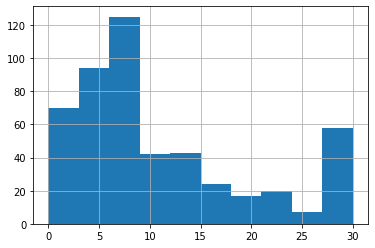

In [ ]:
user_prod['avg_days_since_last_bought'].hist()

In [ ]:
g3 = nx.Graph()
edges = list(user_prod.itertuples(index=False, name=None))

In [ ]:
g3.add_weighted_edges_from(edges)

## Louvian

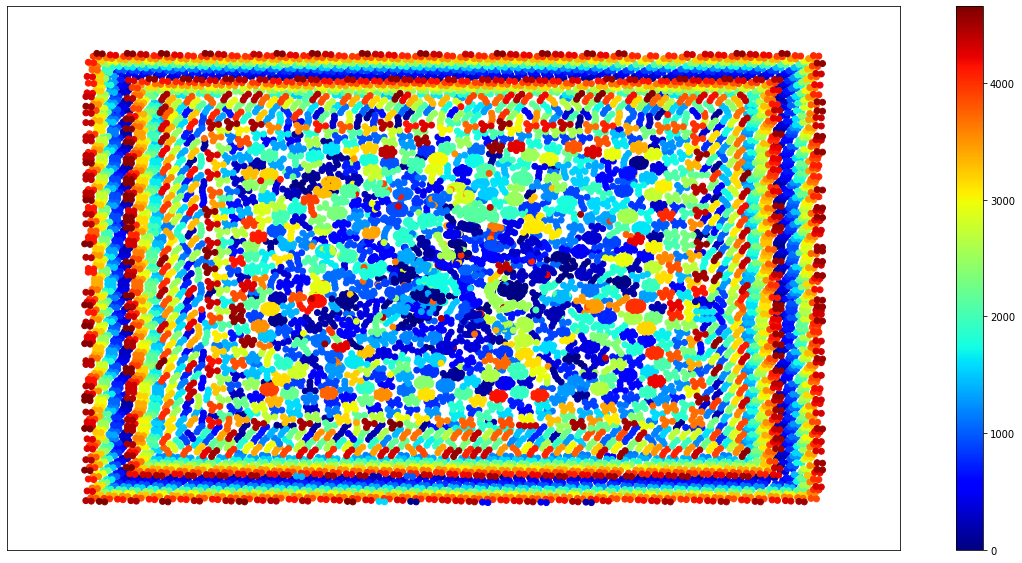

In [ ]:
g3, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g3, resolution=1.0, random_state=42, weight='weight')
edges = g3.edges()
Feature_color_sub = color_list_community
node_size = 35

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(g3, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(g3, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [ ]:
partition = community_louvain.best_partition(g3, resolution=1.0, random_state=42, weight='weight')

In [ ]:
cprint(f"modularity {community_louvain.modularity(partition,g3)}", 'blue')
nodes = list(partition.keys())
community_num = list(partition.values())
community_info = pd.DataFrame({'nodes':nodes,'community_num':community_num})
cprint(f"unique communities: {community_info['community_num'].unique()} community count {community_info['community_num'].nunique()}", "yellow")

modularity 0.9968970938915612
unique communities: [   0    1    2 ... 1016  250 2237] community count 4656


In [ ]:
community_summary = community_info['community_num'].value_counts().sort_values(ascending=False).to_frame('community_size').reset_index().rename(columns={'index':'community_num'}).head(10)
community_summary.head()

,community_num,community_size
0,425,10
1,380,9
2,288,7
3,9,6
4,379,5


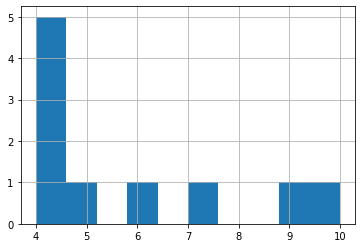

In [ ]:
community_summary['community_size'].hist()

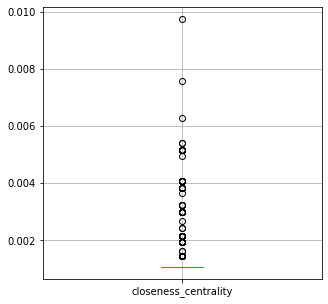

In [ ]:
louvain_closeness = pd.DataFrame.from_dict([nx.closeness_centrality(g3)])
louvain_closeness.iloc[0].to_frame('closeness_centrality').boxplot(figsize=(5,5), grid=True)

In [ ]:
c_gr = community_info.groupby(by=['community_num'])
community_summary['community_avg_days'] = None
for name, group in c_gr:
  ns = group['nodes'].to_list()
  community_avg_days = user_prod[user_prod['user_id'].isin(ns)]['avg_days_since_last_bought'].mean()
  community_summary.loc[community_summary['community_num']==name,'community_avg_days'] = community_avg_days


In [ ]:
community_summary.head()

,community_num,community_size,community_avg_days
0,425,10,9.55469
1,380,9,9.125
2,288,7,12.5
3,9,6,9.79688
4,379,5,14.25


## Leiden

In [ ]:
leiden_partition = la.find_partition(ig.Graph.from_networkx(g3), la.CPMVertexPartition, resolution_parameter = 0.01, seed=42, n_iterations=10);

In [ ]:
cprint(leiden_partition.summary() + " with modularity: " + str(round(leiden_partition.q,4)),'blue', attrs=['bold'])

Clustering with 924 elements and 424 clusters with modularity: 0.9967


## Markov

In [ ]:
adjacency_matrix = nx.to_scipy_sparse_matrix(g3)
markov_communities = mc.run_mcl(adjacency_matrix, inflation=1.2)
markov_clusters = mc.get_clusters(markov_communities)
markov_modularity = mc.modularity(matrix=markov_communities, clusters=markov_clusters)
msg = f"number of markov cluster {len(markov_clusters)} with modularity value {round(markov_modularity,2)}"
cprint(msg, 'blue', attrs=['bold'])

number of markov cluster 459 with modularity value 0.5


# **`Cost Optimization through promotional strategies: Linear Programming`**

When a specific product is being repurchased from a well-known community the objective would be to optimize for the cost of promotional stateges namely:


*   Free shipping cost (x1)
*   Cross sell coupan cost (x2)
*   Same Day Delivery cost (x3)
*   Membership cost (x4)

Custom decision variable relationsip should be added in this step duing optimization, learnt from the past informations of the organization.

Few assumptions has been made in this step (synthetic data generation) as the actual data was not present in the selected dataset.





## Assumptions: Marketing Cost optimization per product per community

In [ ]:
promotional_strategies = ['roi_free_shipping','roi_cross_sell_coupan','roi_same_day_delivery','roi_membership']

In [ ]:
np.random.seed(0)
rois = np.random.dirichlet((3, 4, 5, 11), size = len(products))
np.random.shuffle(rois)

In [ ]:
rois = pd.DataFrame(data=rois, columns=promotional_strategies)
product_rois = pd.concat([products, rois], axis=1)
product_rois.head(n=10)

,product_id,product_name,aisle_id,department_id,roi_free_shipping,roi_cross_sell_coupan,roi_same_day_delivery,roi_membership
0,1,Chocolate Sandwich Cookies,61,19,0.313453,0.102797,0.139610,0.444140
1,2,All-Seasons Salt,104,13,0.109697,0.151064,0.364433,0.374807
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0.172660,0.281077,0.198873,0.347390
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0.267150,0.205626,0.206874,0.320351
4,5,Green Chile Anytime Sauce,5,13,0.052143,0.191365,0.256165,0.500327
5,6,Dry Nose Oil,11,11,0.137652,0.137523,0.209854,0.514970
6,7,Pure Coconut Water With Orange,98,7,0.022467,0.246196,0.170779,0.560558
7,8,Cut Russet Potatoes Steam N' Mash,116,1,0.108915,0.139210,0.258715,0.493160
8,9,Light Strawberry Blueberry Yogurt,120,16,0.238022,0.203668,0.207923,0.350387
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,0.088212,0.223175,0.253586,0.435027


In [ ]:
# assumption of the product id to be bought so that its related information can be picked.
product_id = product_rois['product_id'].sample().squeeze()
p_details = product_rois[product_rois['product_id']==product_id].squeeze()
p_details

product_id                                        30529
product_name             Stage 2 Pear Pumpkin Baby Food
aisle_id                                             92
department_id                                        18
roi_free_shipping                              0.162065
roi_cross_sell_coupan                          0.171811
roi_same_day_delivery                          0.287272
roi_membership                                 0.378853
Name: 30528, dtype: object

In [ ]:
free_shipping_budget_lower_bound = 500
cross_selling_coupan_budget_lower_bound = 200
same_day_delivery_budget_lower_bound = 170
plotform_membership_budget_lower = 300
plotform_membership_budget_upper = 900

total_budget_across_all_promotional_activities = 5000

## Simplex Method formulation and it's solution: Marketing Cost optimization per product per community

In [ ]:
prob = LpProblem("marketing_roi_maximization", LpMaximize)

In [ ]:

x1 = LpVariable("x1", lowBound=free_shipping_budget_lower_bound)
x2 = LpVariable("x2", lowBound=cross_selling_coupan_budget_lower_bound)
x3 = LpVariable("x3", lowBound=same_day_delivery_budget_lower_bound)
x4 = LpVariable("x4", lowBound=plotform_membership_budget_lower, upBound= plotform_membership_budget_upper)

# Assumptions: These relationships has been learnt over a period of time for an organization
prob += x1 + x2 + x3 + x4 <= total_budget_across_all_promotional_activities
prob += 2 * x1 + 0.3 * x2 + 1.8 * x3 + 0.9 * x4 <=2500
prob += x2<= 0.5 * (x1 + x2 + x3 + x4)
prob += x3+x4 >= 0.5 * (x1 + x2+ x3+ x4)
prob += x4 <= 2.5 * x3

prob += round(p_details['roi_free_shipping'],2) * x1 + round(p_details['roi_cross_sell_coupan'],2) * x2 + round(p_details['roi_same_day_delivery'],2) * x3 + round(p_details['roi_membership'],2) * x4

In [ ]:
print(prob)

marketing_roi_maximization:
MAXIMIZE
0.16*x1 + 0.17*x2 + 0.29*x3 + 0.38*x4 + 0.0
SUBJECT TO
_C1: x1 + x2 + x3 + x4 <= 5000

_C2: 2 x1 + 0.3 x2 + 1.8 x3 + 0.9 x4 <= 2500

_C3: - 0.5 x1 + 0.5 x2 - 0.5 x3 - 0.5 x4 <= 0

_C4: - 0.5 x1 - 0.5 x2 + 0.5 x3 + 0.5 x4 >= 0

_C5: - 2.5 x3 + x4 <= 0

VARIABLES
500 <= x1 Continuous
200 <= x2 Continuous
170 <= x3 Continuous
300 <= x4 <= 900 Continuous



In [ ]:
prob.solve()

1

In [ ]:
for v in prob.variables():
    msg = v.name + "=" + str(v.varValue)
    cprint(msg, 'blue', attrs=['bold'])

cprint("Objective = %f" % (prob.objective.value()), 'yellow')

x1=500.0
x2=632.35294
x3=323.52941
x4=808.82353
Objective = 588.676470
